In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import json
%matplotlib inline
sns.set_style('dark')

#import libraries for statistical analysis
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


#import libraries for parallel processing
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings

#import custom utils including persistence testbench
from model_persistence import get_persistence_dataset, train_test_split, walk_forward_evaluation, calculate_errors, plot_error
from create_day_types import get_days_dummies

## ARIMA Models

ARIMA stands for Autoregressive Integrated Moving Average. It uses a linear combination of past time steps, and moving averages to predict t.

## Contents 
1. ARIMA parameters analysis
2. ARIMA multi-step training and evaluation


#### ARIMA Models Evaluated
1. Multi-step output for ARIMA


ARIMA takes only a stationary time series.

We will use the ARIMA model from statsmodels.api which takes the following arguments:
- p: is the number of lag observations in the model and can be estimated from Autocorrelation plots
- d: the number of times raw observations are differenced in order to make the series stationary. This is determined with a Dicky-Fuller test.
- q: the side of the moving average window. The order of moving average.

In [2]:
#load the dataset and create the train and test sets.
data = get_persistence_dataset(transformed=True)

#split using default date 2017-12-31
train, test = train_test_split(data)
train.head(3)

Train start and stop dates 2015-01-01 00:00:00 2017-12-31 00:00:00
Test start and stop dates 2018-01-01 00:00:00 2018-12-31 00:00:00


,t-0 h_0,t-0 h_1,t-0 h_2,t-0 h_3,t-0 h_4,t-0 h_5,t-0 h_6,t-0 h_7,t-0 h_8,t-0 h_9,...,t-0 h_14,t-0 h_15,t-0 h_16,t-0 h_17,t-0 h_18,t-0 h_19,t-0 h_20,t-0 h_21,t-0 h_22,t-0 h_23
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,25385.0,24382.0,22734.0,21286.0,20264.0,19905.0,20010.0,20377.0,20094.0,20637.0,...,24672.0,23528.0,23118.0,23606.0,26447.0,28020.0,29014.0,29571.0,29031.0,26798.0
2015-01-02,27070.0,24935.0,23214.0,22540.0,22096.0,22066.0,22275.0,23025.0,23699.0,25834.0,...,29241.0,27973.0,27320.0,27157.0,29045.0,31967.0,33266.0,33668.0,32426.0,29705.0
2015-01-03,25564.0,23584.0,22194.0,21296.0,21145.0,21316.0,21674.0,22127.0,22756.0,24654.0,...,26416.0,25362.0,24770.0,24501.0,24992.0,27964.0,29694.0,29874.0,28979.0,26863.0


In [3]:
train.index.min(), train.index.max(),test.index.min(), test.index.max()

(Timestamp('2015-01-01 00:00:00'),
 Timestamp('2017-12-31 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2018-12-31 00:00:00'))

##### Stationary and Differencing of the dataset

Set of daily mean data was stationary over the course of a year. Here we test if the hourly data is stationary using the Adfuller Test over a period of 24 hrs, 1 week and a month of lags (24 * 7).

***Null Hypothesis***: The dataset is non-stationary and therefore differencing must be carried out.

If p-value is < 0.05 (two tailed test), we reject the null and assume that the time series is stationary.

In [4]:
#flatten the train set because the statistical model only accepts univariate series
train_flat = train.values.flatten()

Stationary test over **1 day.**

In [5]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic      -27.582837
p-value               0.000000
#Lags                24.000000
Observations      26279.000000
dtype: float64


Stationary test over **1 week.**

In [7]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24*7)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic   -7.804579e+00
p-value           7.339533e-12
#Lags             1.680000e+02
Observations      2.613500e+04
dtype: float64


Stationary test over **1 month**.

In [8]:
adful_t = sm.tsa.adfuller(train_flat, maxlag=24*30)
print(pd.Series(adful_t[0:4], index=['Test Statistic','p-value','#Lags','Observations']))

Test Statistic       -4.354917
p-value               0.000356
#Lags               720.000000
Observations      25583.000000
dtype: float64


All p-values for different time intervals are significantly >0.05. Therefore, can reject the null hypothesis that series is non-stationary and that differencing is needed. So differencing will not be needed. It is assumed that the dataset is stationary.

Therefore the default model parameter for d (the differncing value) is 0. We will also invesitgate a differencing parameter of 24 and 168 corresponding with the previous day, and the previous week.

##### Autocorrelation and partial autocorrelation

Description of the plots:

ACF - Describes the direct and indirect relationships between lagging (shifted) autoregressive features. I.e. the relationships between t, t-1, t-2, t-3 etc. taking into account the interrelatinships between features, in this case t-1 and t-2, t-2 and t-3 etc.

PACF - Describes only the direct relationships between lagging (shifted) and autoregressive features.

p (AR): Determining the autoregressive hyperparameter value p, is best described as the number of lags beyond which there is no significant relationship. This is seen in the ACF as the point at which plot values lie outside the significance band (light blue horizontal band)

q (MR): Determining the moving average hyperparameter value q, is described as the direct relationship with the lag feature and the feature.

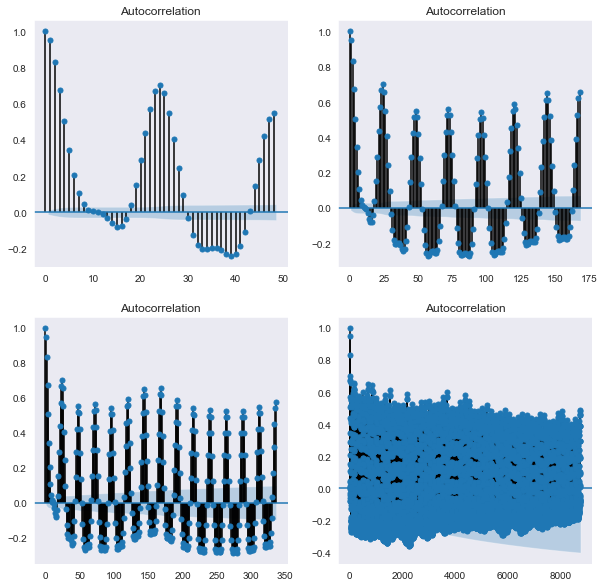

In [9]:
#plot the ACF with lags of: 2 days, 1 wk, 2 wks and 1 yr
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [48, 24*7, 24*14, 24*365]

for lag, ax in zip(lags, axs.flatten()):
    plot_acf(train_flat, lags=lag, ax=ax)
plt.show()

Graph Interpretations:

The autocorrelation plot shows significant positive corelations in the first 9 lags. However in this problem we are attempting to forecast the next 24 hours and using a lag less than 24 does not capture the full context of a short-term day ahead forecast.

The cyclic pattern of the autoregressive features is apprent in the plots. In the ARIMA model the assumption is that beyond the chosen lag point (p), there is no correlation. Observing the bottom right plot we see this point occurs around approximately 4000 lags (approximately 1/2 year).

For the scope of this project calculating with 4000 lags is not feasible. We will focus on lag points 24 (previous day), 48 (previous two days), 168 (previous week).

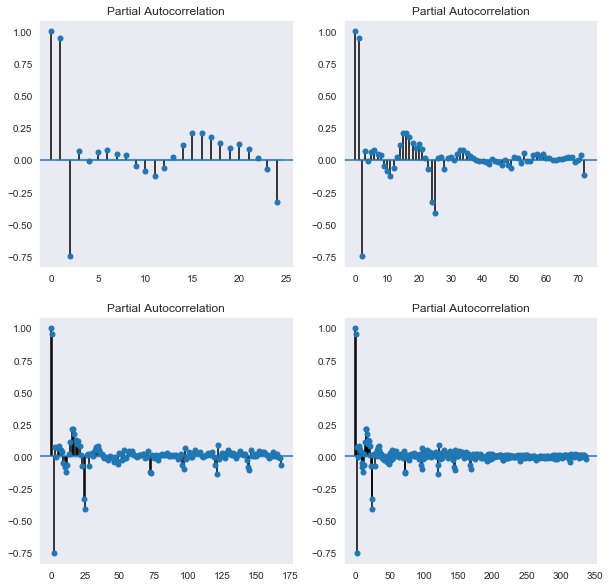

In [10]:
#plot the ACF with lags of: 1 day, 3 days, 1 wk and 2 wks
fig, axs = plt.subplots(2,2, figsize=(10,10))

lags = [24, 24*3, 24*7, 24*14]

for lag, ax in zip(lags, axs.flatten()):
    plot_pacf(train_flat, lags=lag, ax=ax)
plt.show()

### ARIMA Model: Baselines

The baseline parametres for the ARIMA model are chosen as (p, d, q) = (24, 0, 0). This implies 24 autoregressive features are computed for each day in the training set. Because this is computationally intensive we will run this for 1/365 test cycle of the walk forward validation and log the training time.

In [12]:
#Seeing how long it would take to implement 1 forecasting pd to estimate run time on a larger scale

def test_run_ARIMA(train_flat):
    #setup a model instence
    model_24 = ARIMA(train_flat, order=(24, 0, 0))

    #fit the model
    model_fit_24 = model_24.fit()

    #run the 24 interval forecast and return the operation time
    forecast_24, std_24, intervals_24 = model_fit_24.forecast(24)
    
    return forecast_24, std_24, intervals_24
    
%time forecast_24, std_24, intervals_24 = test_run_ARIMA(train_flat)    

CPU times: user 34min 30s, sys: 15.7 s, total: 34min 46s
Wall time: 18min 37s


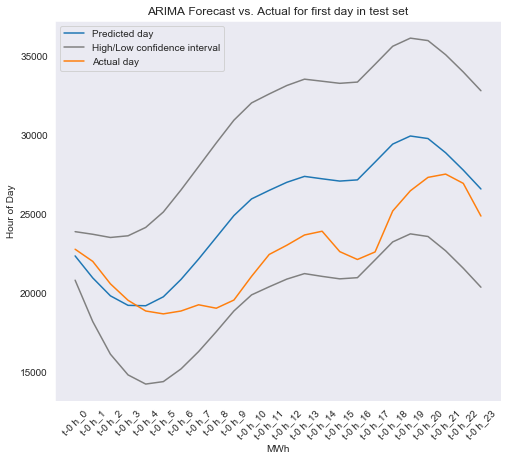

In [13]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast vs. Actual for first day in test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

This forecast is based on 3 years of training to forecast 24 hrs/1 day's worth of energy load.

Forecast is going in direction as needed, close to actual values in beginning and within confidence intervals-- good sign.

In [14]:
#calculate the root mean squared error of the single test run
print('ARIMA 1 step walk forward RMSE: {0:.2f} MWh' .format(mean_absolute_error(test.iloc[0,:], forecast_24)))

ARIMA 1 step walk forward RMSE: 2828.96 MWh


This RMSE is close to forecasts made by Prophet, but Prophet still slightly lowwer in RMSE.

##### ARIMA model function

Before moving to calculate the walk forward validation on the entire training set using only one autoregressive feature. This will allow testing of the funcitons written to calcualte RMSE and plotting of hour by hour RMSE.

In [15]:
#define a model to insert into the training rig created in the persistence workbook
def arima_model(history, config):
    
    #convert dataframe to numpy array and flatten into column vector
    history_flat = history.values.flatten()
    
    p,d,q = config
    
    #initalize the ARIMA model
    model = ARIMA(history_flat, order=(p, d, q))
    
    #fit model
    model_fit = model.fit()
    
    #generate forecast for the next 24 hours
    forecast, _, _ = model_fit.forecast(24)
    
    #save the model
    #name = 'model-' + str(datetime.datetime.now()) +'.pkl'
    #model_fit.save(name)
    
    #print('Done. Model Saved.')
    
    return forecast

### ARIMA Model: Computation Estimations

##### Full test set walk forward: computation time estimate

The baseline evaluation above fit the model on 3 years of hourly data and forecast the first day in the training set. Following the walk forward validation methodology this process is run ***for the entire test set***. Baseline time results for 1/365 of the test forecast:

CPU Time 57 min 46 s
Wall time 15 min 09 s

The process used multiple cores to complete. On an average of 4 cores for the job the total training set would take 15 min * 365 test days. Or a total of 91 hours (3.8 days).

##### Grid search hyperparameters computation time

Following the analysis of AC and PAC plots 45 combinations of hyperparmeters have been identified of interest. Assuming similar computation times for each hyperparmeter combination as the baseline the total computer time is:

***Computation time:*** 45 hyperparmeters * 91 hours = 4095 hours using 4 cores per job (4*45 cores for multicore processing.

##### Assessing implementation options

**1. Run ARIMA on a GPU**

According to [this post](https://github.com/statsmodels/statsmodels/issues/4752) the ARIMA model is not deployable on a GPU. 

The [Hyperlearn repo](https://github.com/danielhanchen/hyperlearn) did look promising as a resource that implements multithreaded processing of Sklearn, statsmodels etc. However at writing it does not support an ARIMA model implementation.

**2. Condense the training and test sets**

In the original problem formulation the walk forward validation problem was set up with 3 years of training data and 1 year test for a total of 4 years.

By dropping the training size to 1 year, and forecasting the first 3 months of the original test set we drop the total data by ~65%.

**3. Consider using SARIMAX**

The SARIMAX model is more complex, and uses mode features resulting in a larger statespace to calculate. According to the documentation the ARIMA model is mintained at minimum while the SARIMA model has newer implementations. It is not clear that the SAIRMAX is in fact a faster algorithem. In this notebook we will run a test against a ARIMA and compare

##### Computation tests on smaller dataset

Here we implement a condsened version of the walk forward validation set. The specific details of the datasets is described below:

- Train: 2017-01-01 to 2017-12-31
- Test: 2018-01-01 to 2018-03-31 
- Model: ARIMA (24,0,0) predicting the frist 1/90 days of the test set

In [20]:
#setup the train and test with a condensed training set
data = get_persistence_dataset(start='2017-01-01', stop='2018-03-31')
train_condensed, test_condensed = train_test_split(data, split_date='2017-12-31')
train_flat_condensed = train_condensed.values.flatten()

Train start and stop dates 2017-01-01 00:00:00 2017-12-31 23:00:00
Test start and stop dates 2018-01-01 00:00:00 2018-03-31 23:00:00


In [21]:
print('Total days in train set {}'.format(train_condensed.shape[0]))
print('Total days in test set {}'.format(test_condensed.shape[0]))

Total days in train set 8760
Total days in test set 2160


In [22]:
#repeat the vanilla ARIMA with 24 auroregressive features
%time forecast_ARMA, std_AMRA, intervals_AMRA = test_run_ARIMA(train_flat_condensed)

CPU times: user 22min 14s, sys: 15.2 s, total: 22min 29s
Wall time: 12min 21s


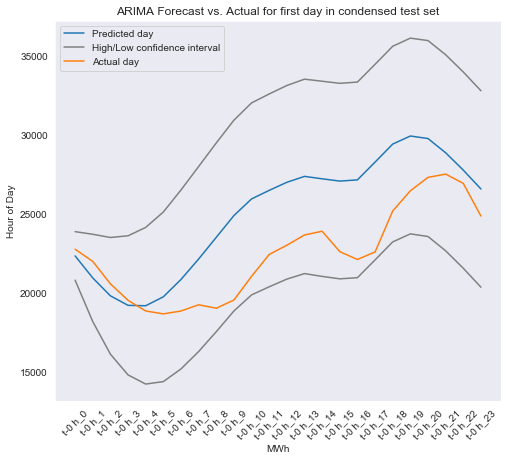

In [23]:
#plot the result and get an idea if the forecast is in the right direction
fig = plt.figure(figsize=(8,7))

plt.plot(forecast_24, label='Predicted day')
plt.plot(intervals_24[:,0], label='High/Low confidence interval', color='gray')
plt.plot(intervals_24[:,1], color='gray')
plt.plot(test.iloc[0,:], label='Actual day')
plt.xticks(rotation=45)
plt.title('ARIMA Forecast vs. Actual for first day in condensed test set')
plt.xlabel('MWh')
plt.ylabel('Hour of Day')
plt.legend()
plt.show()

In [57]:
# print('ARIMA 1 step walk forward RMSE: {0:.2f} MWh' .format(np.sqrt(mean_squared_error(test_condensed.iloc[0,:], forecast_ARMA))))